<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)

In [3]:
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Του ακριβού το ψουμίν, ο λίμπουρος εν το τρώει (Κύπρος) -- predicted as: Eyvoia


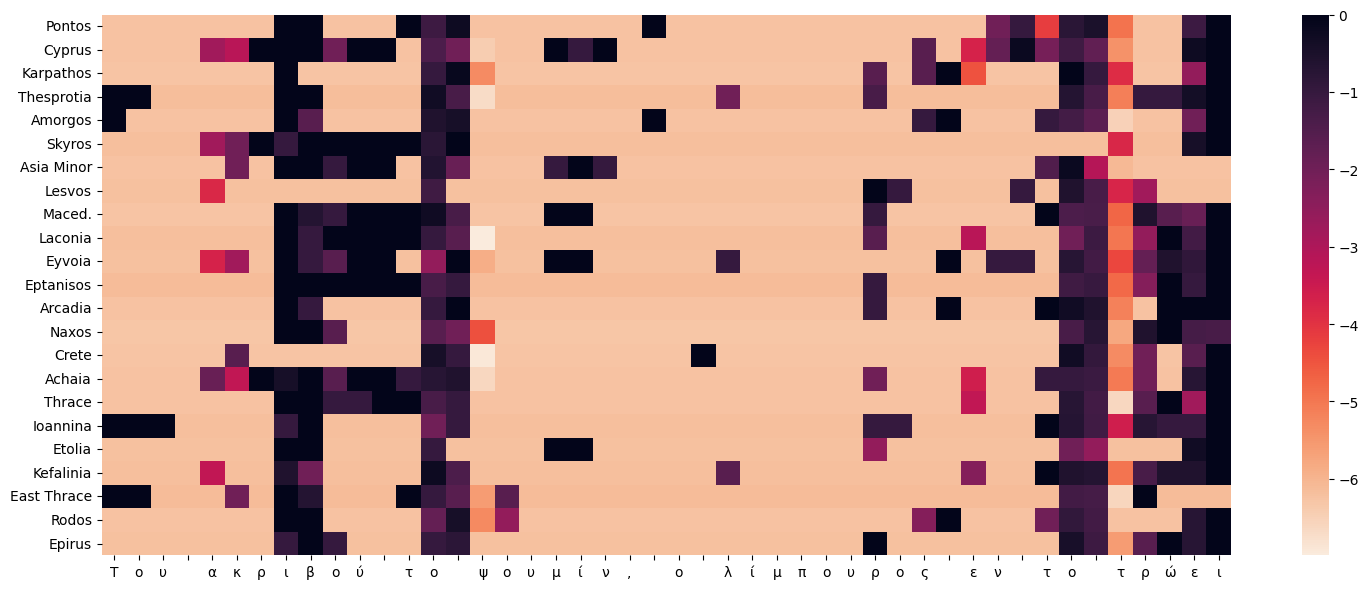

In [9]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

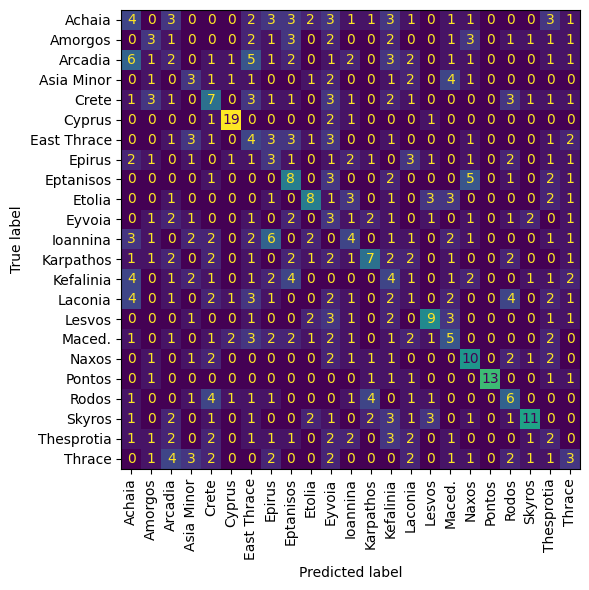

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

* Benchmarking standard text classifiers, on top of chanracter n-grams

In [12]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


In [13]:
# benchmarking text classification algorithms
def benchmark_clf(train, dev):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('KNN', KNeighborsClassifier),
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=2, lowercase=True)
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        preds = locator.predict(test.text.values) 
        print(f'{algo_name}\n{classification_report(test.area.values, preds)}')

benchmark_clf(train, dev)

SVM
                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10

In [14]:
# inference on test data:
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [15]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
1,"Άβολος ο νους, διπλός ο κόπος","{Νίσυρος, Μικρά Ασία>Τσεσμές (Κρήνη)}",2,"{Νίσυρος, Μικρά Ασία}",2,"[(36.58904575, 27.16918402255752), (38.1846366..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θράκη, Θήρα (Σαντορίνη)}",2,"[(40.8464241, 25.8759377), (36.4044251, 25.395..."
3,"Άβουλος νους, διπλός ο κόπος","{Αμοργός, Κρήτη, Ρόδος}",3,"{Αμοργός, Κρήτη, Ρόδος}",3,"[(36.85252415, 25.89848696771565), (35.3084952..."
4,Άβουλος ο νους διπλός ο κόπος,"{Σάμος>Μαραθόκαμπος, Θράκη>Μάδυτος, Ρόδος, Θρά...",5,"{Θράκη, Σάμος, Ήπειρος, Ρόδος}",4,"[(40.8464241, 25.8759377), (37.9574332, 23.710..."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Λέρος, Αργολίδα}",2,"[(37.56626615, 22.85593894780862), (37.1494507..."
3200,πονάει το δόντι,"{Θεσσαλία>Τρίκαλα, Φωκίδα}",2,"{Θεσσαλία, Φωκίδα}",2,"[(38.4998681, 22.24878032919352), (39.5594194,..."
3201,"που Πάτρα, που Φλομίτσι!","{Μεσσηνία>Αβία>Κάμπος, Μάνη>Αβία}",2,"{Μεσσηνία, Μάνη}",2,"[(36.986899050000005, 21.82712495001949), (41...."
3202,τού έδειξε τα δόντια,"{Αρκαδία>Τεγέα, Εύβοια}",2,"{Εύβοια, Αρκαδία}",2,"[(38.0368583, 23.6689264), (38.49417235, 23.91..."


In [16]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",Ήπειρος,2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
2117,Ξένοι πόνοι ξένα γέλια,"{Κάλυμνος, Ρόδος}",2,"{Κάλυμνος, Ρόδος}",Ρόδος,2,"[(37.00262545, 26.992424179156217), (36.172629..."
2094,Νιός ήμουν και γέρασα,"{Αμοργός, Μικρά Ασία>Βουρλά}",2,"{Αμοργός, Μικρά Ασία}",Μικρά Ασία,2,"[(36.85252415, 25.89848696771565), (38.1846366..."
2089,Νηστικιά αρκούδα δε χορεύει,"{Μικρά Ασία>Κυδωνία, Κεφαλληνία>Ομαλά}",2,"{Κεφαλληνία, Μικρά Ασία}",Κεφαλληνία,2,"[(38.2379344, 20.560883), (38.1846366, 23.5122..."
2085,"Νηστεύει ο δούλος του Θεού, γιατί ψωμί δεν έχει!","{Ήπειρος, Αχαΐα>Πάτρα}",2,"{Αχαΐα, Ήπειρος}",Αχαΐα,2,"[(38.0692748, 21.87273042232539), (37.9574332,..."


* Showing on ones our classifier said Cyrpus

In [17]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
3057,Του κλέφτη κλέφτεις του;,"{Κύπρος>Κυθραία, Λακωνία, Κύπρος}",3,"{Λακωνία, Κύπρος}",Κύπρος,2,"[(34.9823018, 33.1451285), (36.76027945, 22.79..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [18]:
import optuna
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

def objective(trial):

    regressor_name = trial.suggest_categorical("regressor", [
        "LinearRegression",
        "ElasticNet", 
        "KNeighborsRegressor",
        "RandomForestRegressor", 
        "ExtraTreesRegressor"
        ])

    if regressor_name == "LinearRegression": 
        regressor = LinearRegression()
    elif regressor_name == "ElasticNet":
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
        l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
        regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elif regressor_name == "KNeighborsRegressor":
        n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        p = trial.suggest_categorical('p', [1, 2])
        regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                        weights=weights, 
                                        p=p)
    elif regressor_name == "RandomForestRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        regressor = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
                                          n_jobs=-1)
    elif regressor_name == "ExtraTreesRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2023-06-07 22:54:41,442] A new study created in memory with name: no-name-2e5e41fa-997b-4209-8834-26aa248eeb3a
[I 2023-06-07 22:54:42,218] Trial 0 finished with value: 0.12157069318821215 and parameters: {'regressor': 'LinearRegression'}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 22:54:42,523] Trial 1 finished with value: 0.12157069318821215 and parameters: {'regressor': 'LinearRegression'}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 22:54:43,673] Trial 2 finished with value: 0.1134337043245528 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 434, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 22:54:44,462] Trial 3 finished with value: -0.5972544800274928 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 22:54:44,770] Trial 4 finis

[I 2023-06-07 22:55:22,441] Trial 35 finished with value: 0.15071031567962248 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004977948336573973, 'l1_ratio': 0.5222266672820896}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:22,761] Trial 36 finished with value: 0.008130330667162278 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 45, 'weights': 'distance', 'p': 2}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:24,631] Trial 37 finished with value: 0.12310786421189035 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 398, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:24,791] Trial 38 finished with value: 0.15027988318465435 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004707324547378336, 'l1_ratio': 0.47080728115502546}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:24,87

[I 2023-06-07 22:55:37,549] Trial 70 finished with value: 0.15148046718605132 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006283501794953927, 'l1_ratio': 0.8803506330812736}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:37,698] Trial 71 finished with value: 0.15143954923315067 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006117124122849895, 'l1_ratio': 0.8945128198162323}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:37,872] Trial 72 finished with value: 0.14589655040581823 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0002971065287579941, 'l1_ratio': 0.8858806168961358}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:38,023] Trial 73 finished with value: 0.15125216736551111 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007238435351070021, 'l1_ratio': 0.8058944775744582}. Best is trial 32 with value: 0.15163393203401773.
[I 2023-06-07 22:55:38,159] Trial 74 finished with v

[I 2023-06-07 22:55:51,113] Trial 105 finished with value: 0.15001761634465263 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004262773724170321, 'l1_ratio': 0.72674344113628}. Best is trial 100 with value: 0.15165187569767818.
[I 2023-06-07 22:55:51,690] Trial 106 finished with value: -0.00843428589894698 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 100 with value: 0.15165187569767818.
[I 2023-06-07 22:55:52,151] Trial 107 finished with value: 0.10461414655735006 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 232, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 100 with value: 0.15165187569767818.
[I 2023-06-07 22:55:52,320] Trial 108 finished with value: 0.1423185743662465 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00021873314775301664, 'l1_ratio': 0.8379441958748597}. Best is trial 100 with value: 0.15165187569767818.
[I 2023-06-07 22:55:52

[I 2023-06-07 22:56:06,478] Trial 140 finished with value: 0.15143180392608813 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006879787794659996, 'l1_ratio': 0.8260858060475285}. Best is trial 128 with value: 0.15170095802953903.
[I 2023-06-07 22:56:06,637] Trial 141 finished with value: 0.15071161064613586 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004699769369606495, 'l1_ratio': 0.7736574103572882}. Best is trial 128 with value: 0.15170095802953903.
[I 2023-06-07 22:56:06,788] Trial 142 finished with value: 0.1516801397606086 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006303124619942306, 'l1_ratio': 0.7991473754218671}. Best is trial 128 with value: 0.15170095802953903.
[I 2023-06-07 22:56:06,939] Trial 143 finished with value: 0.15168152265530851 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006220506937635162, 'l1_ratio': 0.8048329670646696}. Best is trial 128 with value: 0.15170095802953903.
[I 2023-06-07 22:56:07,084] Trial 144 finishe

[I 2023-06-07 22:56:15,708] Trial 175 finished with value: 0.15048967270164323 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00045407176337712395, 'l1_ratio': 0.7461122008133894}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:15,871] Trial 176 finished with value: 0.14998616198369294 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008533078784019981, 'l1_ratio': 0.7887673282772848}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:16,032] Trial 177 finished with value: 0.1516758978150662 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006471147154560555, 'l1_ratio': 0.7671217043078351}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:16,180] Trial 178 finished with value: 0.14593502870503103 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0011020797438647681, 'l1_ratio': 0.7628312285751783}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:16,330] Trial 179 finish

[I 2023-06-07 22:56:26,803] Trial 210 finished with value: 0.15133303749879928 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005267762717226711, 'l1_ratio': 0.7882883822063148}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:26,957] Trial 211 finished with value: 0.1516658651100754 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006519594668501185, 'l1_ratio': 0.7586894782644751}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:27,107] Trial 212 finished with value: 0.15159565023632193 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006718944881243049, 'l1_ratio': 0.7642587659923655}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:27,256] Trial 213 finished with value: 0.15112289733985512 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007426412141753208, 'l1_ratio': 0.803614116504928}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:27,414] Trial 214 finished

[I 2023-06-07 22:56:35,232] Trial 245 finished with value: 0.1507271783066581 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007894528945832701, 'l1_ratio': 0.7465273380442934}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:35,392] Trial 246 finished with value: 0.1505215791418489 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00045730483132817737, 'l1_ratio': 0.655883907519367}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:35,556] Trial 247 finished with value: 0.14818566316600795 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0003570929366640773, 'l1_ratio': 0.8266621297856473}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:35,694] Trial 248 finished with value: 0.1478112428186079 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0010013561856963911, 'l1_ratio': 0.7197696662384481}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:35,785] Trial 249 finished 

[I 2023-06-07 22:56:46,007] Trial 280 finished with value: 0.1514928862767972 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005968865194045624, 'l1_ratio': 0.8793581354672076}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:48,042] Trial 281 finished with value: 0.12415873109319826 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 495, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:48,187] Trial 282 finished with value: 0.148771526938526 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0009422495241382596, 'l1_ratio': 0.7288612178186871}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:48,343] Trial 283 finished with value: 0.15110873414047876 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005009146800024595, 'l1_ratio': 0.7618852851623972}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:

[I 2023-06-07 22:56:56,677] Trial 315 finished with value: 0.1497736231377096 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00041534559301766846, 'l1_ratio': 0.7578539128202428}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:56,835] Trial 316 finished with value: 0.151320282696129 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006310722661684828, 'l1_ratio': 0.9220628988618411}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:56,981] Trial 317 finished with value: 0.15026483184760853 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008302524829514935, 'l1_ratio': 0.794194800363259}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:57,139] Trial 318 finished with value: 0.15109701588118493 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005046180506504659, 'l1_ratio': 0.6697746898113708}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:56:57,292] Trial 319 finished 

[I 2023-06-07 22:57:10,026] Trial 350 finished with value: 0.1305784595494826 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 256, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:10,177] Trial 351 finished with value: 0.14980646049160698 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008671560602338883, 'l1_ratio': 0.7858207660562384}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:10,329] Trial 352 finished with value: 0.15097801531070712 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007624691742674091, 'l1_ratio': 0.7680189603407279}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:10,480] Trial 353 finished with value: 0.15090283984219272 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006092401567410678, 'l1_ratio': 0.4645879804521405}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07

[I 2023-06-07 22:57:23,309] Trial 385 finished with value: 0.00381968973607425 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 50, 'weights': 'uniform', 'p': 1}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:23,457] Trial 386 finished with value: 0.15021563167958324 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008350081143214554, 'l1_ratio': 0.7133332667628869}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:23,573] Trial 387 finished with value: 0.0935956266658424 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.004816878682709547, 'l1_ratio': 0.7791789505188615}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:23,698] Trial 388 finished with value: 0.12426180272122096 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0024015288912172706, 'l1_ratio': 0.8207204565064418}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:23,785] Trial 389 finished with 

[I 2023-06-07 22:57:36,013] Trial 420 finished with value: 0.14546339339609538 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00027765188427741633, 'l1_ratio': 0.7724202436723091}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:36,167] Trial 421 finished with value: 0.1516970036704417 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006148358866270873, 'l1_ratio': 0.7498032515184414}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:36,320] Trial 422 finished with value: 0.15092996210192794 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007673454558382931, 'l1_ratio': 0.7424008564279676}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:36,481] Trial 423 finished with value: 0.15027733059603715 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00044093000191740316, 'l1_ratio': 0.7257269360997761}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:36,606] Trial 424 finis

[I 2023-06-07 22:57:49,521] Trial 455 finished with value: 0.10837623447106551 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0035778372110550965, 'l1_ratio': 0.8023221719476044}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:56,573] Trial 456 finished with value: 0.13529503680422172 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 316, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:56,659] Trial 457 finished with value: -0.0004066991582208246 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.09179924032024457, 'l1_ratio': 0.6979024037424999}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:56,749] Trial 458 finished with value: 0.12157069318821215 and parameters: {'regressor': 'LinearRegression'}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:57:56,909] Trial 459 finished with value: 0.15022637

[I 2023-06-07 22:58:03,970] Trial 490 finished with value: 0.14854305546909474 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0009398598325445112, 'l1_ratio': 0.8368603529714794}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:58:04,275] Trial 491 finished with value: 0.014672697216268016 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 21, 'weights': 'distance', 'p': 2}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:58:04,428] Trial 492 finished with value: 0.1512246977269937 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007316053415324073, 'l1_ratio': 0.7477009118046141}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:58:05,804] Trial 493 finished with value: 0.12123247937507728 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 289, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 164 with value: 0.15170537109033977.
[I 2023-06-07 22:58

In [19]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.15170537109033977
best trial: FrozenTrial(number=164, state=TrialState.COMPLETE, values=[0.15170537109033977], datetime_start=datetime.datetime(2023, 6, 7, 22, 56, 13, 513199), datetime_complete=datetime.datetime(2023, 6, 7, 22, 56, 13, 687282), params={'regressor': 'ElasticNet', 'alpha': 0.000624584728970956, 'l1_ratio': 0.7710010533680905}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'regressor': CategoricalDistribution(choices=('LinearRegression', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor')), 'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=164, value=None)
best params: {'regressor': 'ElasticNet', 'alpha': 0.000624584728970956, 'l1_ratio': 0.7710010533680905}


In [20]:
if best_params['regressor'] == 'LinearRegression':
    best_regressor = LinearRegression()
elif best_params['regressor'] == 'ElasticNet':
    best_regressor = ElasticNet(alpha=best_params["alpha"], 
                                l1_ratio=best_params["l1_ratio"])
elif best_params['regressor'] == 'KNeighborsRegressor':
    best_regressor = KNeighborsRegressor(
        n_neighbors=best_params["n_neighbors"], 
        weights=best_params["weights"],
        p=best_params["p"])
elif best_params['regressor'] == 'RandomForestRegressor':
    best_regressor = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"])
elif best_params['regressor'] == 'ExtraTreesRegressor':
    best_regressor = ExtraTreesRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"])
    
vect = TfidfVectorizer(ngram_range=(1, 1), 
                       analyzer="word", 
                       max_df=0.5,
                       min_df=10, 
                       lowercase=True)
pipe = Pipeline([('vect', vect), ('reg', best_regressor)])
pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = pipe.score(test.text.values, test[["lat", "lon"]].values)
score    

0.21332870166754325

In [21]:
predicted_coords = pipe.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.29 & 1.80
MSE of lat and lon: 2.63 & 5.52


* Having arrived at this point, it is worth pointing out that the $\alpha$ parameter of `ElasticNet` is very small:

In [22]:
best_params['alpha']

0.000624584728970956

* This means that in practice `ElasticNet` behaves pretty much like Ordinary Least Squares regression.

* So we could as well just try that one.

In [23]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                       min_df=10, lowercase=True)
    
pipe = Pipeline([('vect', vect), ('reg', LinearRegression())])
    
scores = cross_val_score(pipe, 
                         train.text.values, 
                         train[["lat", "lon"]].values,
                         cv=5,
                         n_jobs=-1)
scores.mean()

0.12157069318821215

In [24]:
pipe = Pipeline([('vect', vect), ('reg', LinearRegression())])
pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = pipe.score(test.text.values, test[["lat", "lon"]].values)
score   

0.19721894514520716

In [25]:
predicted_coords = pipe.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.31 & 1.82
MSE of lat and lon: 2.70 & 5.57


## Finding terms pushing North, South, West, and East

In [26]:
importance_pd = pd.DataFrame({"feature":pipe["vect"].get_feature_names_out(), 
                              "lat": pipe["reg"].coef_[0, :],
                              "lon": pipe["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [27]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,3.635892,-0.032554
601,σάββας,3.161245,1.184159
195,διάβολο,2.948192,1.232401
552,πε,2.770396,1.545323
325,κε,2.755401,-0.781987


### Words pushing $\downarrow$ South: lower lat

In [28]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.194844,11.198418
661,τζαί,-4.178668,11.034529
662,τζαι,-4.120808,10.672089
226,εγιώ,-3.835543,5.002954
664,τζι,-3.824139,10.232078


### Words pushing $\rightarrow$ East: higher lon

In [29]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
660,τζ,-4.194844,11.198418
661,τζαί,-4.178668,11.034529
662,τζαι,-4.120808,10.672089
664,τζι,-3.824139,10.232078
233,εμ,-2.805806,7.284577


### Words pushing $\leftarrow$ West: higher lon

In [30]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
115,βαρβάρα,-1.411847,-4.574121
702,τσου,0.507615,-4.082944
157,γελάει,-0.226155,-4.005390
466,ναν,0.649680,-3.835403
107,αφέντη,0.441480,-3.485066
